In [1]:
import os
os.chdir("../../")
print(os.getcwd())

d:\PhD_Projects\Mori-Zwanzig-Autoencoder


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from src.PreProc_Data.DataProc import StackedSequenceDataset
import numpy as np
from src.Eval_MZA import Eval_MZA
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from Data.KS.KS_order import KS
import pandas as pd
import csv

In [3]:
torch.cuda.empty_cache()

exp_dir   = "Pre-trained_Models/KS/KS_Trained_Model"

models = []
exp_name_list = [
                 "sl13_nhu100_numobs8_bs512",\
                 "No_Mem_Prediction"
                ]

for exp_name in exp_name_list:#os.listdir(exp_dir):
    if exp_name != "results" and exp_name != ".DS_Store":
        print(exp_name)
        models.append(Eval_MZA(exp_dir, exp_name))

lt = 93.04  #Lyapunov Time Units

sl13_nhu100_numobs8_bs512
########## Imp Info ##########
System:  KS
No_Mem_Prediction
########## Imp Info ##########
System:  KS
Training without Seqmodel


Plotting Learning Curves

Epoch with Minimum train_error:  13006
Epoch with Minimum test_error:  13177


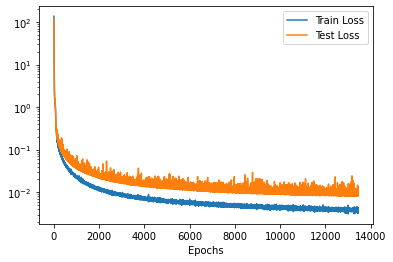

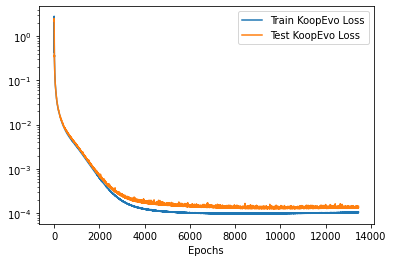

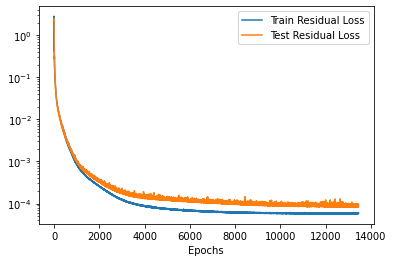

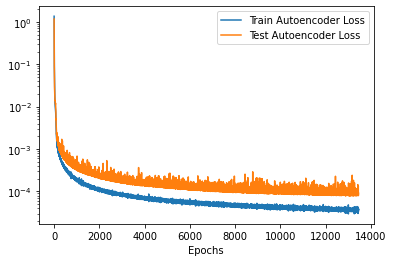

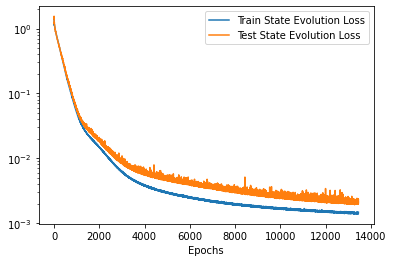

In [4]:
#plot learning curves
models[0].plot_learning_curves()

Loading Model Weights

In [5]:
for i in range(0,len(models)):
    models[i].load_weights(min_test_loss = True)

Loading Data

In [6]:
#Loading Data

model_num = 0
models[model_num].load_and_preproc_data()
models[model_num].create_dataset(mode = "Test")
dataset = models[model_num].test_dataset
num_trajs = models[model_num].test_num_trajs

State Dims:  256
Not normalizing Input
Test_Shape:  (1, 15000, 256)
Time:  0.5193724632263184


Multi Step Prediction

In [7]:
Phi_test = models[0].test_data
print(Phi_test.shape)

(1, 15000, 256)


In [11]:
#multistep prediction
timesteps = 15000
initial_step = 0

initial_conditions = torch.from_numpy(Phi_test[:,initial_step,:]).to(torch.float32).to(models[0].device)

x_ms_hat, xkoop_ms_hat, xseq_ms_hat = [], [], []
Phi_ms_hat  = torch.zeros((len(models),1,timesteps+1,models[0].statedim)).to(models[0].device)
# Phi_ms_koop = torch.zeros((len(models),1,timesteps,models[0].statedim)).to(models[0].device)

print("ic shape:", initial_conditions.shape)

for i in range(len(models)):
    x_hat_temp, Phi_ms_hat[i], xkoop_hat_temp, xseq_hat_temp = models[i].predict_multistep(initial_conditions, timesteps)
    x_ms_hat.append(x_hat_temp)
    xkoop_ms_hat.append(xkoop_hat_temp)
    xseq_ms_hat.append(xseq_hat_temp)
print(Phi_ms_hat.shape)


ic shape: torch.Size([1, 256])
torch.Size([2, 1, 15001, 256])


Figure6a

Text(0, 0.5, 'kinetic energy')

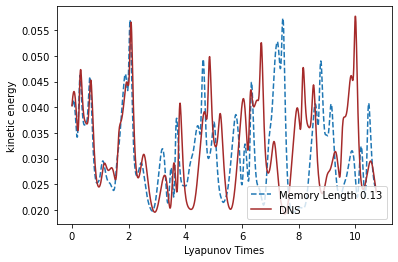

In [12]:
#Figure6a
def KS_kinetic_energy(Phi):
    L = 22
    k = 0.5*np.mean(Phi**2, axis = -1)/L
    return k

plt.figure()

timesteps_ke = 1000
timesteps_dns = 1000
lt = 93.024        #Lyapunov time unit

x = np.arange(timesteps_ke)/lt
x_dns = np.arange(timesteps_dns)/lt

for i in [0]:
    plt.plot(x, KS_kinetic_energy(Phi_ms_hat[i,0,0:timesteps_ke].detach().cpu().numpy()),"--", label = f"Memory Length {round((models[i].seq_len - 1)/lt,2)}")

plt.plot(x_dns[:], KS_kinetic_energy(Phi_test[0,initial_step:timesteps_dns+initial_step]), label = "DNS",color = "brown")

plt.legend(loc='lower right')
plt.xlabel("Lyapunov Times")
plt.ylabel("kinetic energy")


Cross Corelation Factor (Figure 5c)

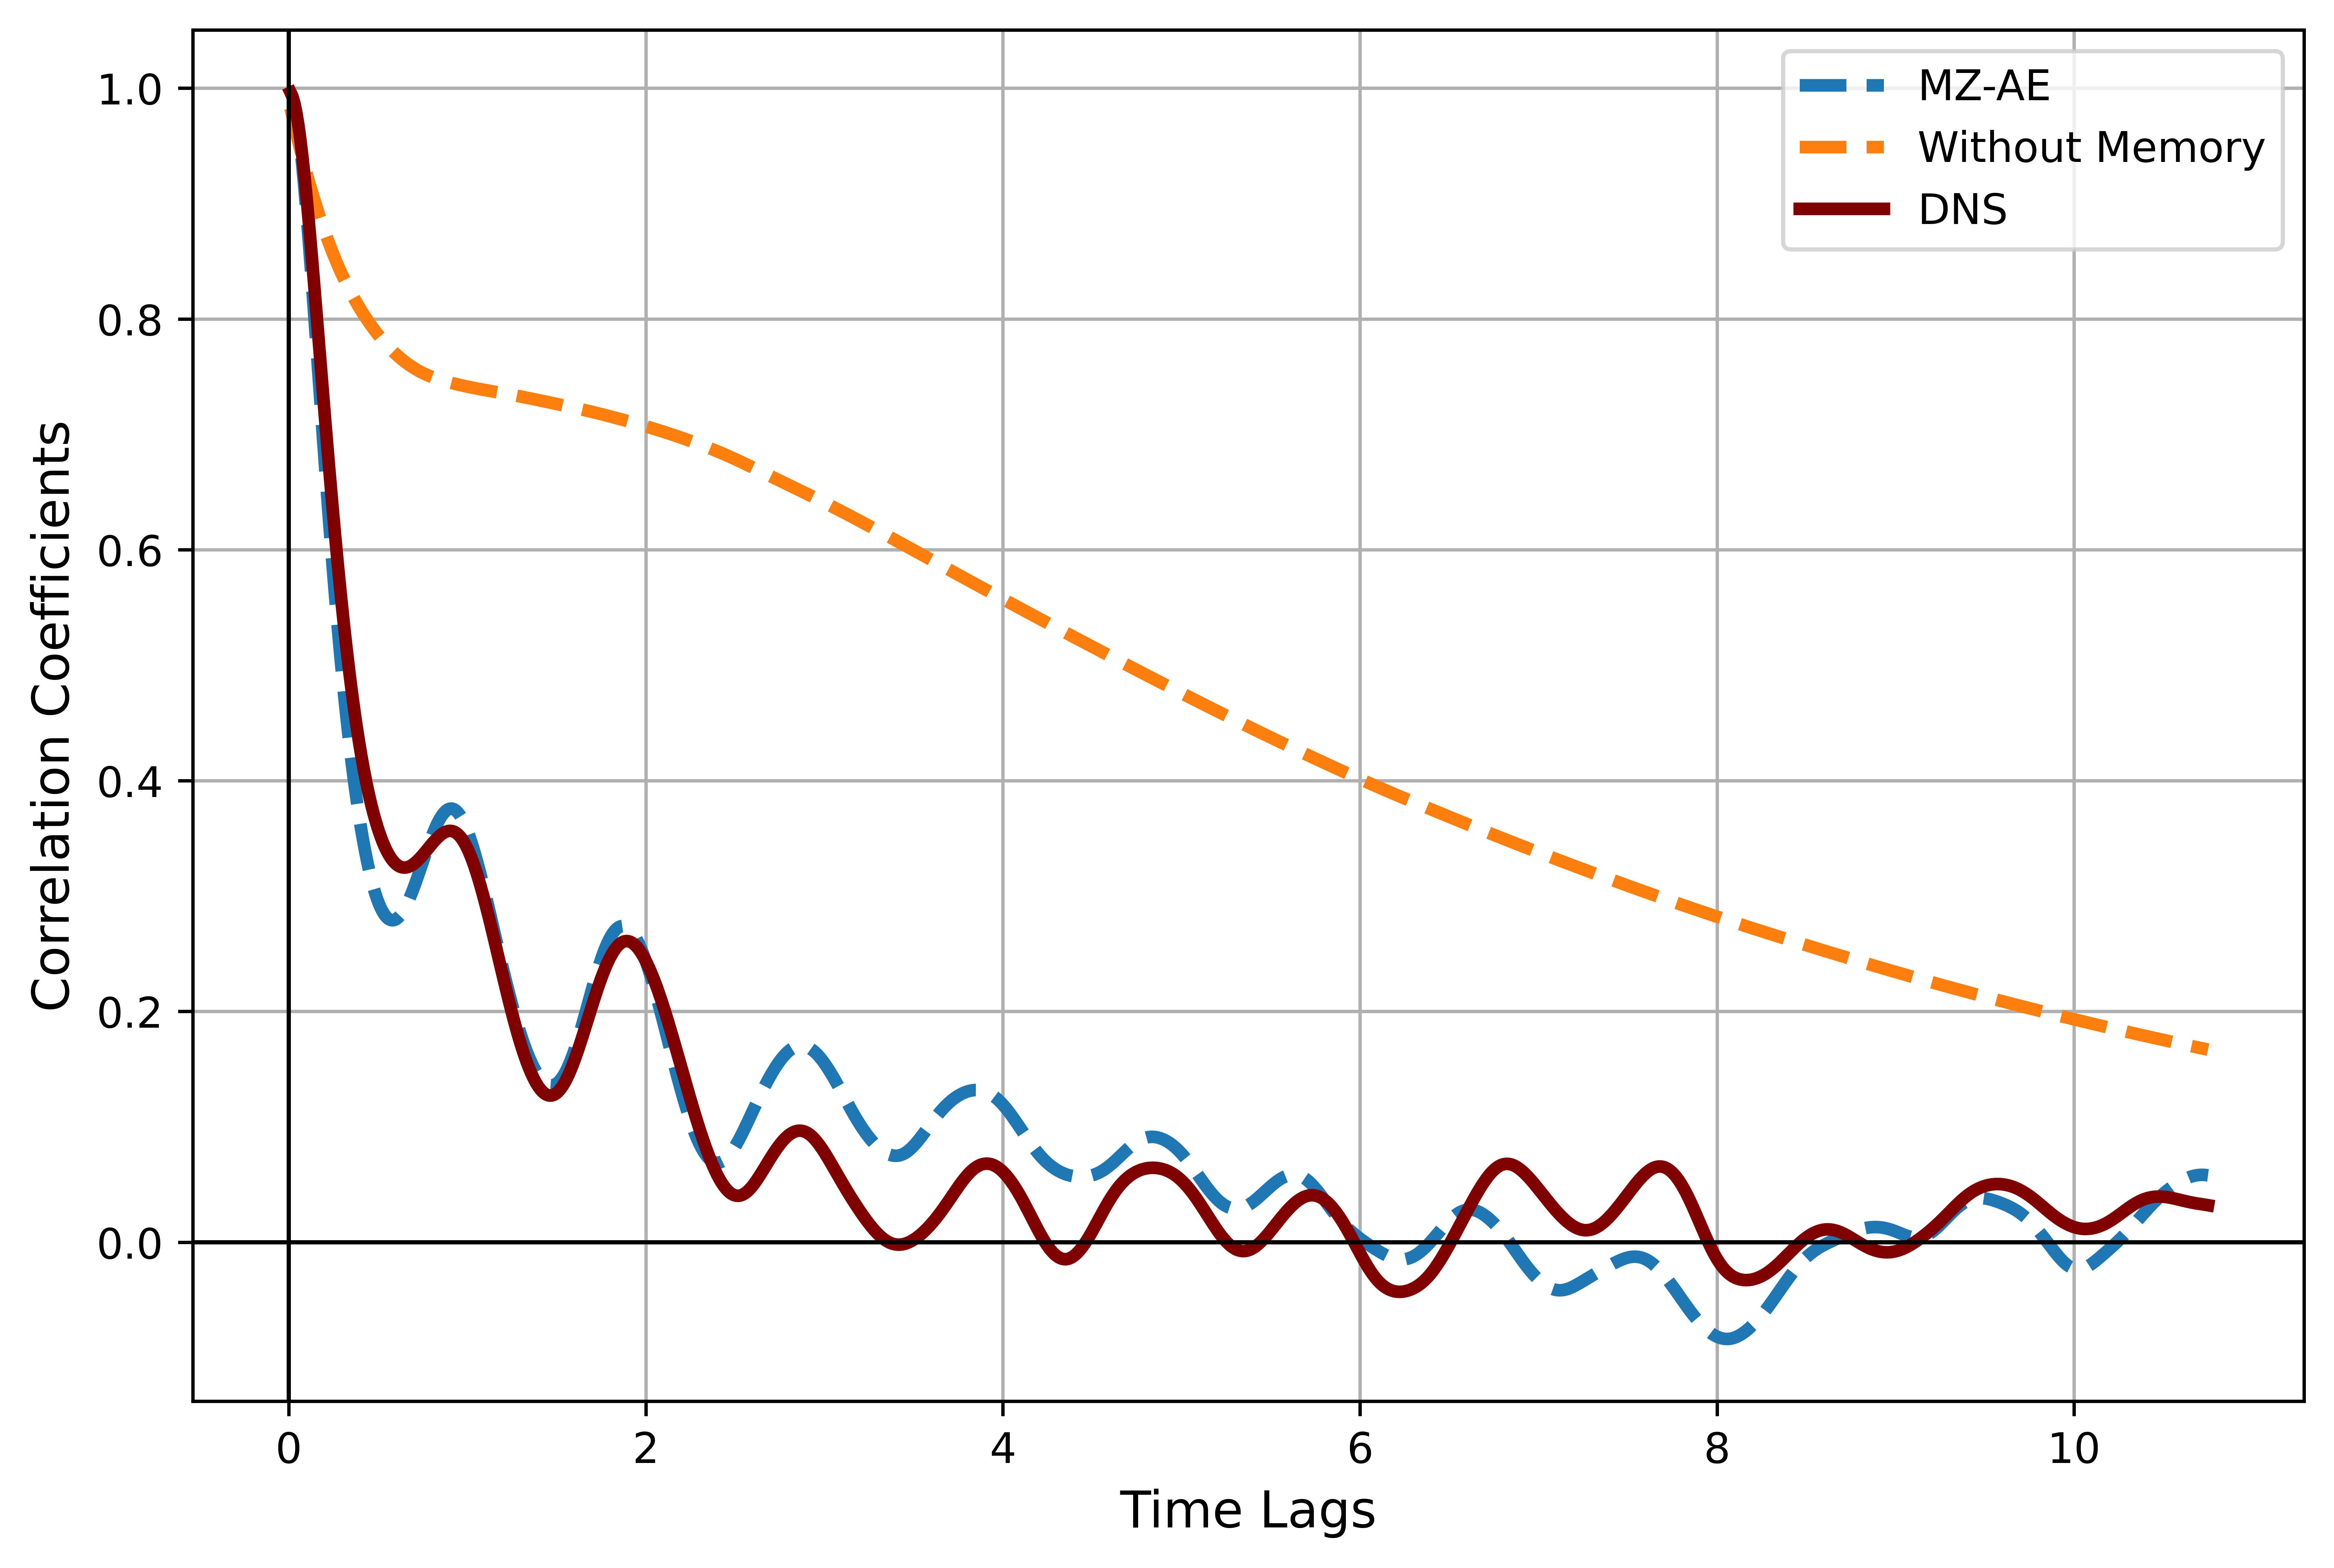

In [21]:
#Cross Corelation Factor (Figure 5c)
timesteps_ccf = 15000
lags = signal.correlation_lags(len(Phi_test[0,initial_step:timesteps_ccf+initial_step,1]), len(Phi_test[0,initial_step:timesteps_ccf+initial_step,2]))/lt

fig, ax =plt.subplots(figsize=(9, 6), dpi = 1000)
i=0
ccf_mzae = Eval_MZA.ccf_values(Phi_ms_hat[i,0,0:timesteps_ccf,0].detach().cpu().numpy(), Phi_ms_hat[i,0,0:timesteps_ccf,1].detach().cpu().numpy())
# lags = signal.correlation_lags(len(Phi_ms_hat[i,0,0:timesteps_ccf,1].detach().cpu().numpy()), len(Phi_ms_hat[i,0,0:timesteps_ccf,2].detach().cpu().numpy()))
Eval_MZA.ccf_plot(lags[timesteps_ccf:timesteps_ccf+1000], ccf_mzae[timesteps_ccf:timesteps_ccf+1000], fig, ax)

i=1
ccf_wm = Eval_MZA.ccf_values(Phi_ms_hat[i,0,0:timesteps_ccf,0].detach().cpu().numpy(), Phi_ms_hat[i,0,0:timesteps_ccf,1].detach().cpu().numpy())
Eval_MZA.ccf_plot(lags[timesteps_ccf:timesteps_ccf+1000], ccf_wm[timesteps_ccf:timesteps_ccf+1000], fig, ax, color = "without mem")

ccf_dns = Eval_MZA.ccf_values(Phi_test[0,initial_step:timesteps_ccf+initial_step,0], Phi_test[0,initial_step:timesteps_ccf+initial_step,1])
# lags = signal.correlation_lags(len(Phi[0,initial_step:timesteps_ccf+initial_step,1]), len(Phi[0,initial_step:timesteps_ccf+initial_step,2]))
Eval_MZA.ccf_plot(lags[timesteps_ccf:timesteps_ccf+1000], ccf_dns[timesteps_ccf:timesteps_ccf+1000], fig, ax, color = "red")


PDF of kinteic energy (Figure 5b)

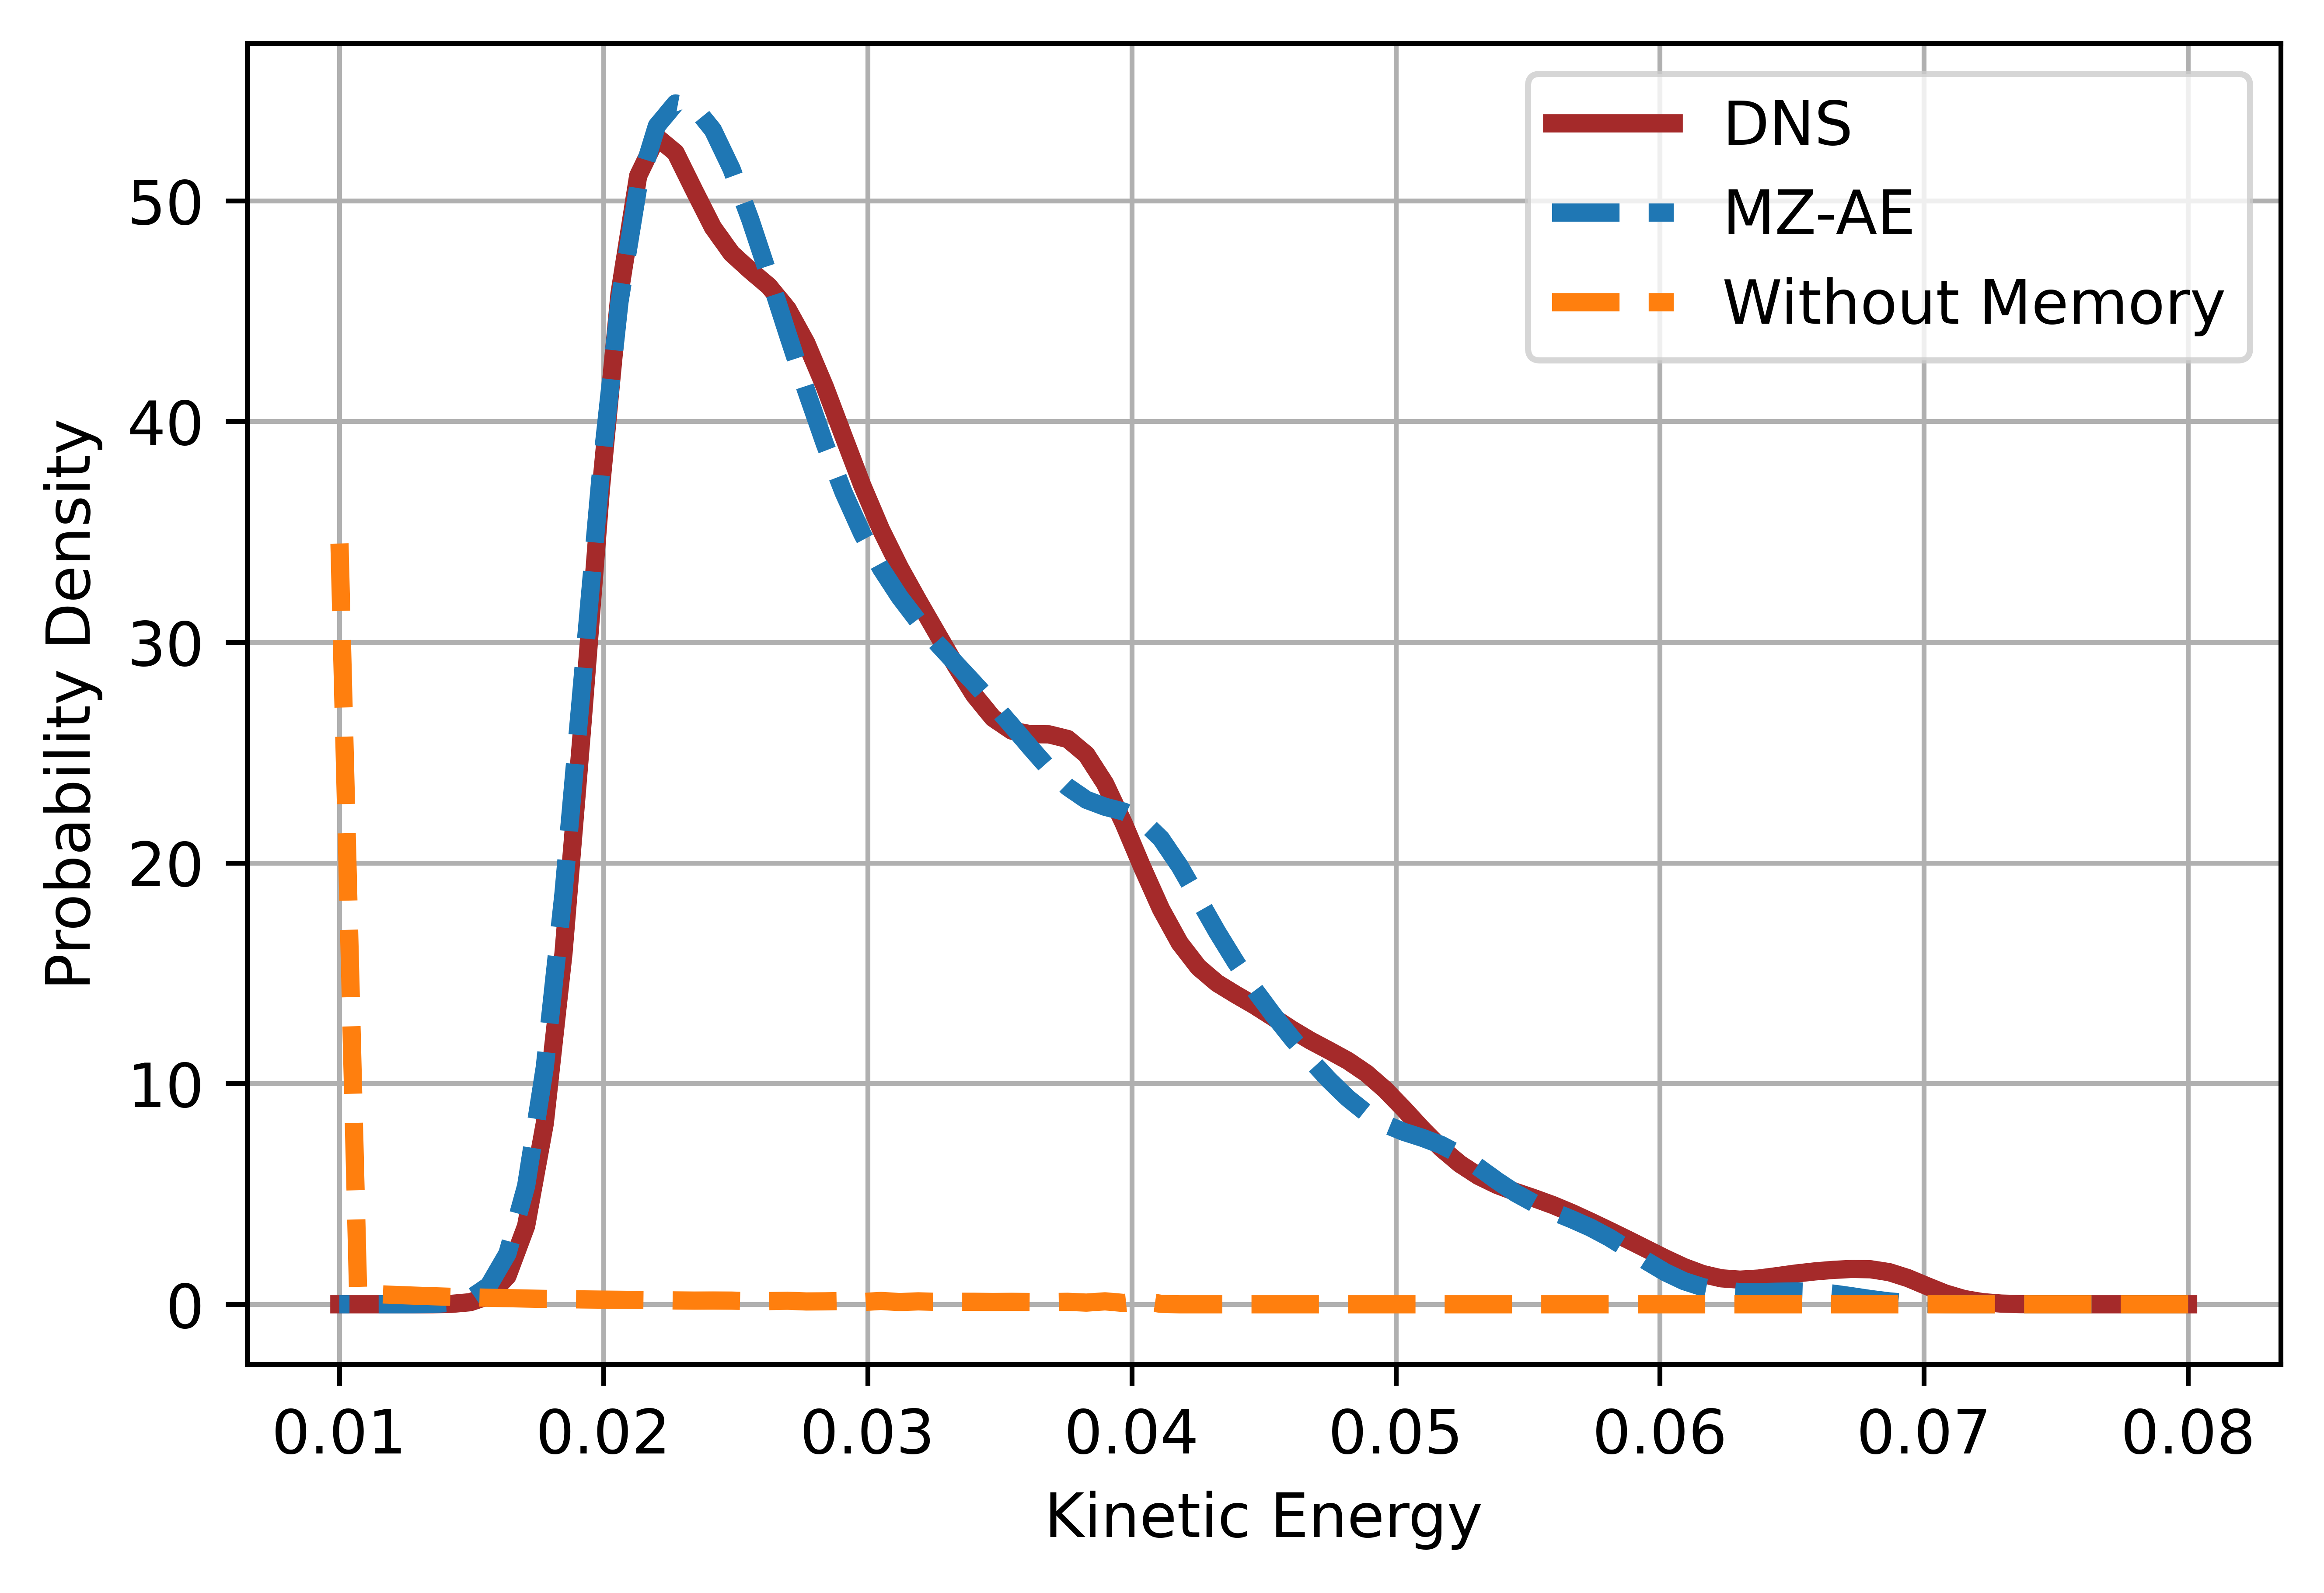

In [22]:
#pdf of kinteic energy (Figure 5b)
import copy
import csv
from scipy.stats import gaussian_kde
def calc_pdf(ke):
        '''
        Input
        -----
        ke (numpy array): [num_trajs timesteps 1]

        Returns
        -------
        StateMSE [timesteps]
        '''

        kde = gaussian_kde(ke)
        # k = np.linspace(min(ke), max(ke), 10000)
        k = np.linspace(0.08, 0.01, 100)
        pdf = kde.evaluate(k)
        return k, pdf

plt.figure(dpi=1000)


k, pdf = calc_pdf(KS_kinetic_energy(Phi_test[0,initial_step:timesteps+initial_step]))
plt.plot(k, pdf, label = "DNS",color = "brown", linewidth=3.0)

for i in [0,1]:
    
    k_p, pdf_p = calc_pdf(KS_kinetic_energy(Phi_ms_hat[i,0,0:6500].detach().cpu().numpy()))
    if i == 0:
        k_p_mzae = copy.deepcopy(k_p)
        pdf_p_mzae = copy.deepcopy(pdf_p)
        plt.plot(k_p, pdf_p , "--", label = f"MZ-AE", linewidth=3.0)
    else:
        k_p_wm = copy.deepcopy(k_p)
        pdf_p_wm = copy.deepcopy(pdf_p)
        plt.plot(k_p, pdf_p , "--", label = f"Without Memory", linewidth=3.0)
    
plt.legend(loc='upper right')

plt.xlabel('Kinetic Energy')
plt.ylabel('Probability Density')
plt.grid("on")


Text(0.5, 0, 'x, space')

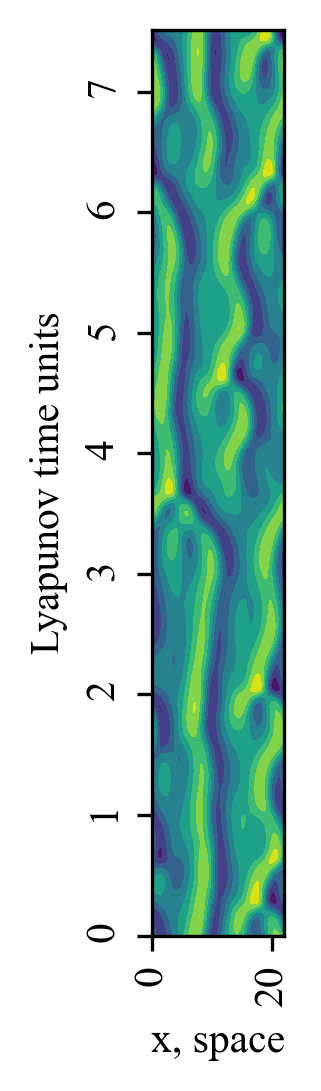

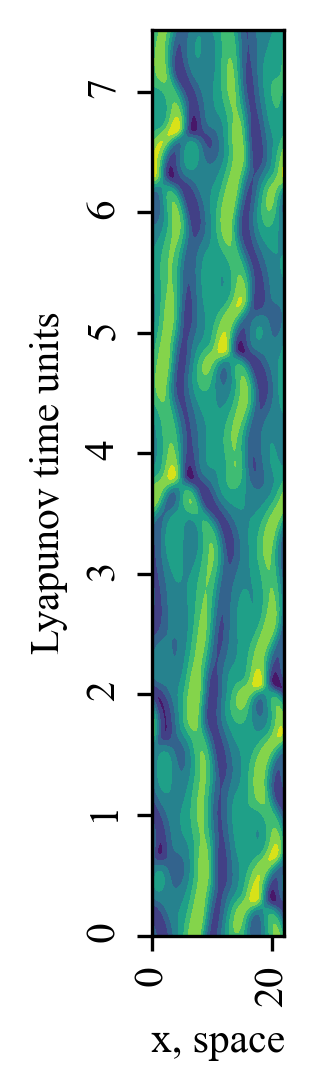

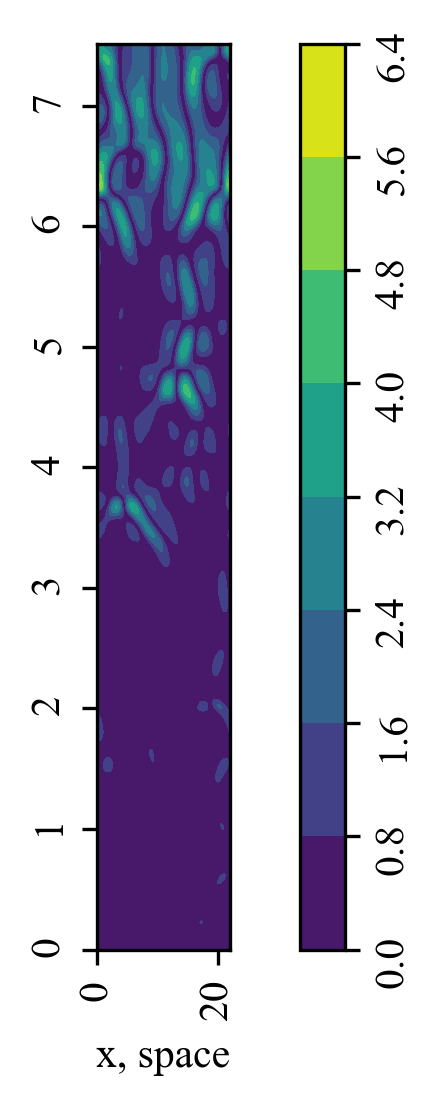

In [23]:
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

#plot snapshot (Figure 4)
timesteps_contour = 700
contour_x = np.linspace(0,22,256)
contour_t = np.arange(timesteps_contour)/lt
contour_X, contour_T = np.meshgrid(contour_x, contour_t)

model_no = 0

plt.figure(dpi=300)
plt.contourf(contour_X, contour_T, Phi_ms_hat[model_no,0,:timesteps_contour,:].detach().cpu().numpy())
plt.xticks(rotation=90)
plt.yticks(rotation=90)
plt.gca().set_aspect(20)
plt.xlabel(r"x, space")


plt.ylabel(r"Lyapunov time units")

plt.figure(dpi=300)
contour_pred = plt.contourf(contour_X, contour_T, Phi_test[0,initial_step:timesteps_contour+initial_step])
# colorbar = plt.colorbar(contour_pred)
# colorbar.ax.tick_params(axis='y', labelsize=16)

plt.gca().set_aspect(20)
plt.xticks(rotation=90)
plt.yticks(rotation=90)
plt.xlabel(r"x, space")
plt.ylabel(r"Lyapunov time units")

plt.figure(dpi=300)

vmin = 0  
vmax = 2   
contour_error =  np.abs(Phi_test[0,initial_step:timesteps_contour+initial_step] - Phi_ms_hat[model_no,0,:timesteps_contour,:].detach().cpu().numpy())#/Phi[0,initial_step:timesteps_contour+initial_step])
clipped_ce = np.clip(contour_error, None, 10)
contour = plt.contourf(contour_X, contour_T, clipped_ce)
colorbar = plt.colorbar(contour)
colorbar.ax.tick_params(axis='y', rotation = 90)
plt.xticks(rotation=90)
plt.yticks(rotation=90)
plt.gca().set_aspect(20)
plt.xlabel(r"x, space")


Energy spectrum (Figure 5a)


[  0.           0.28559933   0.57119866   0.856798     1.14239733
   1.42799666   1.71359599   1.99919533   2.28479466   2.57039399
   2.85599332   3.14159265   3.42719199   3.71279132   3.99839065
   4.28398998   4.56958931   4.85518865   5.14078798   5.42638731
   5.71198664   5.99758598   6.28318531   6.56878464   6.85438397
   7.1399833    7.42558264   7.71118197   7.9967813    8.28238063
   8.56797996   8.8535793    9.13917863   9.42477796   9.71037729
   9.99597663  10.28157596  10.56717529  10.85277462  11.13837395
  11.42397329  11.70957262  11.99517195  12.28077128  12.56637061
  12.85196995  13.13756928  13.42316861  13.70876794  13.99436728
  14.27996661  14.56556594  14.85116527  15.1367646   15.42236394
  15.70796327  15.9935626   16.27916193  16.56476126  16.8503606
  17.13595993  17.42155926  17.70715859  17.99275793  18.27835726
  18.56395659  18.84955592  19.13515525  19.42075459  19.70635392
  19.99195325  20.27755258  20.56315191  20.84875125  21.13435058
  21.419949

(1e-10, 1000000.0)

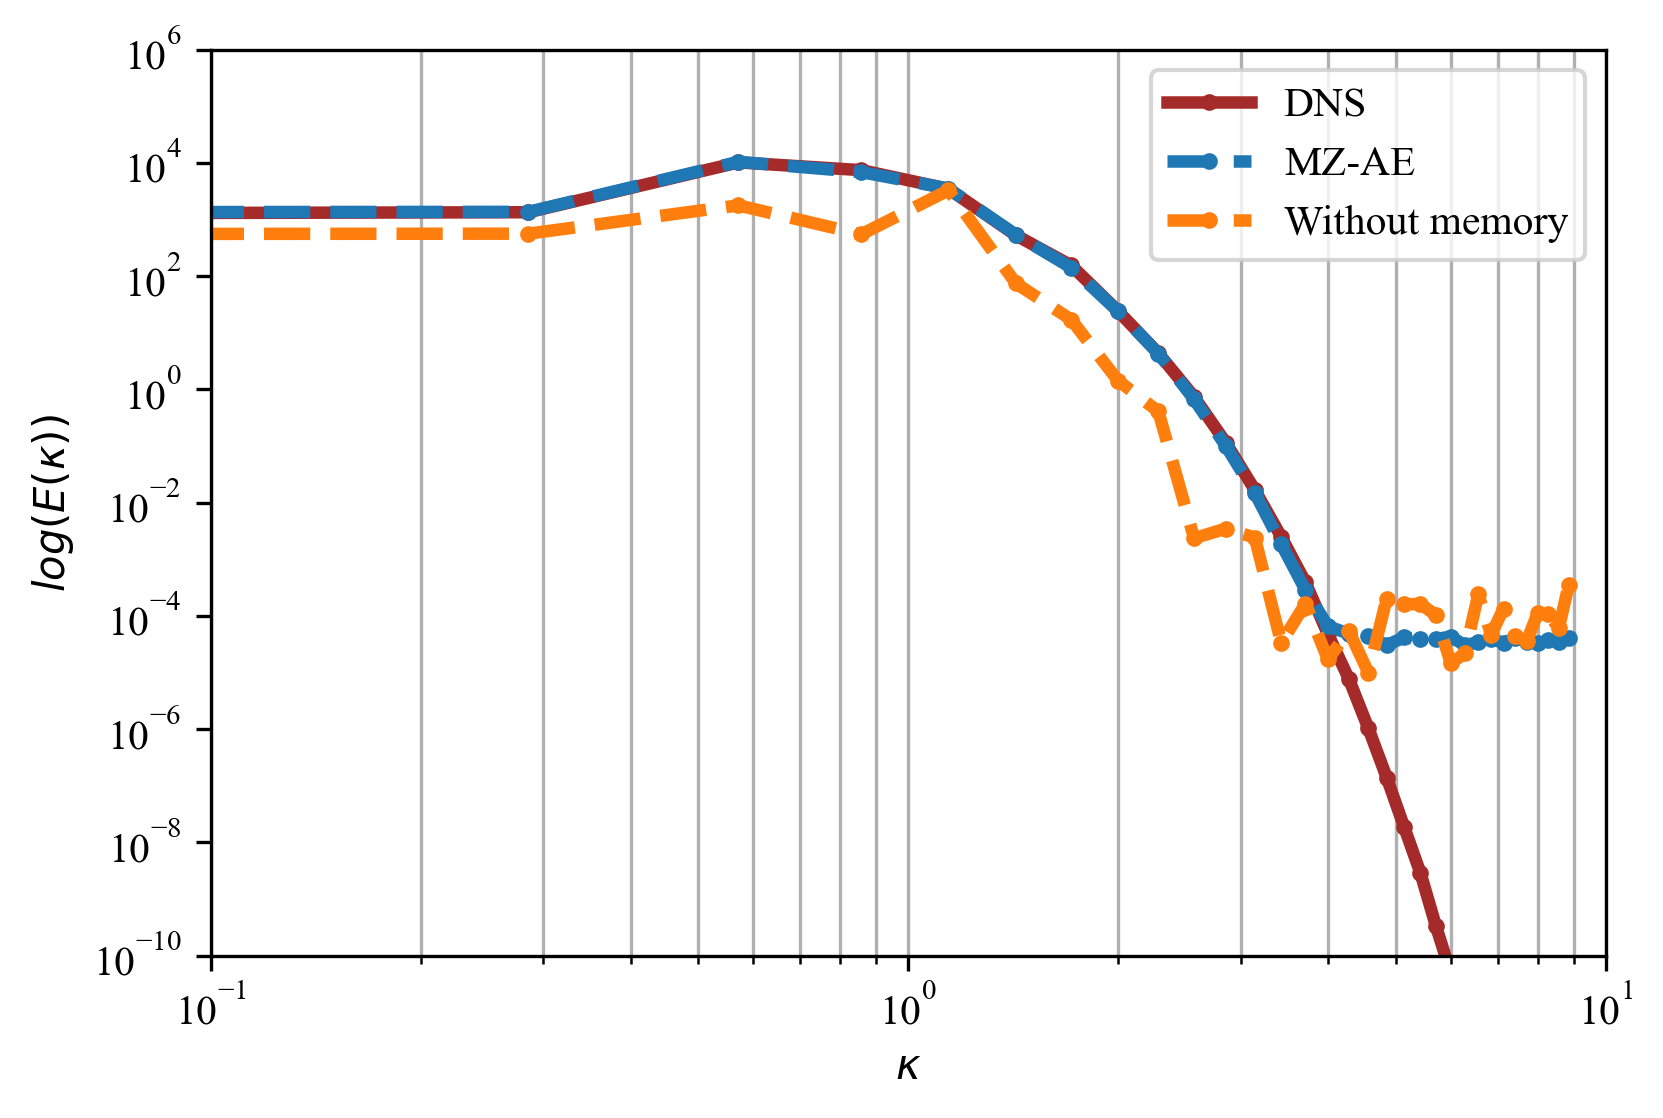

In [24]:
#energy spectrum (Figure 5a)
dt = 0.025
N  = 256
num_trajs = 1
max_n = int(8000/dt)
L = 22/(2*np.pi)#1/np.sqrt(0.085)
kse = KS(dt=dt, N=N, lambda2=1, L = L)

plt.figure(dpi=300)

timesteps_ke = 6500
lt = 93
x = np.arange(1000)/lt

Phi_fft = np.fft.rfft(Phi_test[0,initial_step:timesteps+initial_step], axis = -1)
k_fft = 0.5*np.mean(np.abs(Phi_fft)**2, axis = 0)
plt.loglog(kse.k[:32], k_fft[:32], ".-", label = "DNS",color = "brown", linewidth=3.0)

Phi_ms_hat_fft = np.fft.rfft(Phi_ms_hat.detach().cpu().numpy())
k_fft_ms = 0.5*np.mean(np.abs(Phi_ms_hat_fft)**2, axis = -2)

#Plot for MZ-AE
plt.loglog(kse.k[:32], k_fft_ms[0,0,:32], ".--", label = f"MZ-AE", linewidth=3.0)
#Plot for Without Memory
plt.loglog(kse.k[:32], k_fft_ms[1,0,:32], ".--", label = f"Without memory", linewidth=3.0)
    

plt.grid(True, which="both", axis='x')
plt.legend(loc='upper right')
plt.xlabel(r"$\kappa$")
plt.ylabel(r"$log(E(\kappa))$")
plt.xlim(0.1, 10)  # Set the x-axis limits in log scale
plt.ylim(1e-10, 1e6)  # Set the y-axis limits in log scale

# #Save Data

# data_dict = {"k_p_MZ-AE":k_fft_ms[0,0,:32],"k_p_Without-Memory":k_fft_ms[1,0,:32],"k_p_DNS":k_fft,"k":kse.k[:32]} 

# csv_file_name = 'Plot_csv/KS_KE_spectrum.csv'

# with open(csv_file_name, mode='w', newline='') as csv_file:
#     writer = csv.writer(csv_file)

#     header = data_dict.keys()
#     writer.writerow(header)

#     for row in zip(*data_dict.values()):
#         writer.writerow(row)

### Plotting Latent Space

Plotting seqmodel mode evolution (Figure 6b)

Text(0, 0.5, 'Observables  $  L_{2}$ Norm')

<Figure size 432x288 with 0 Axes>

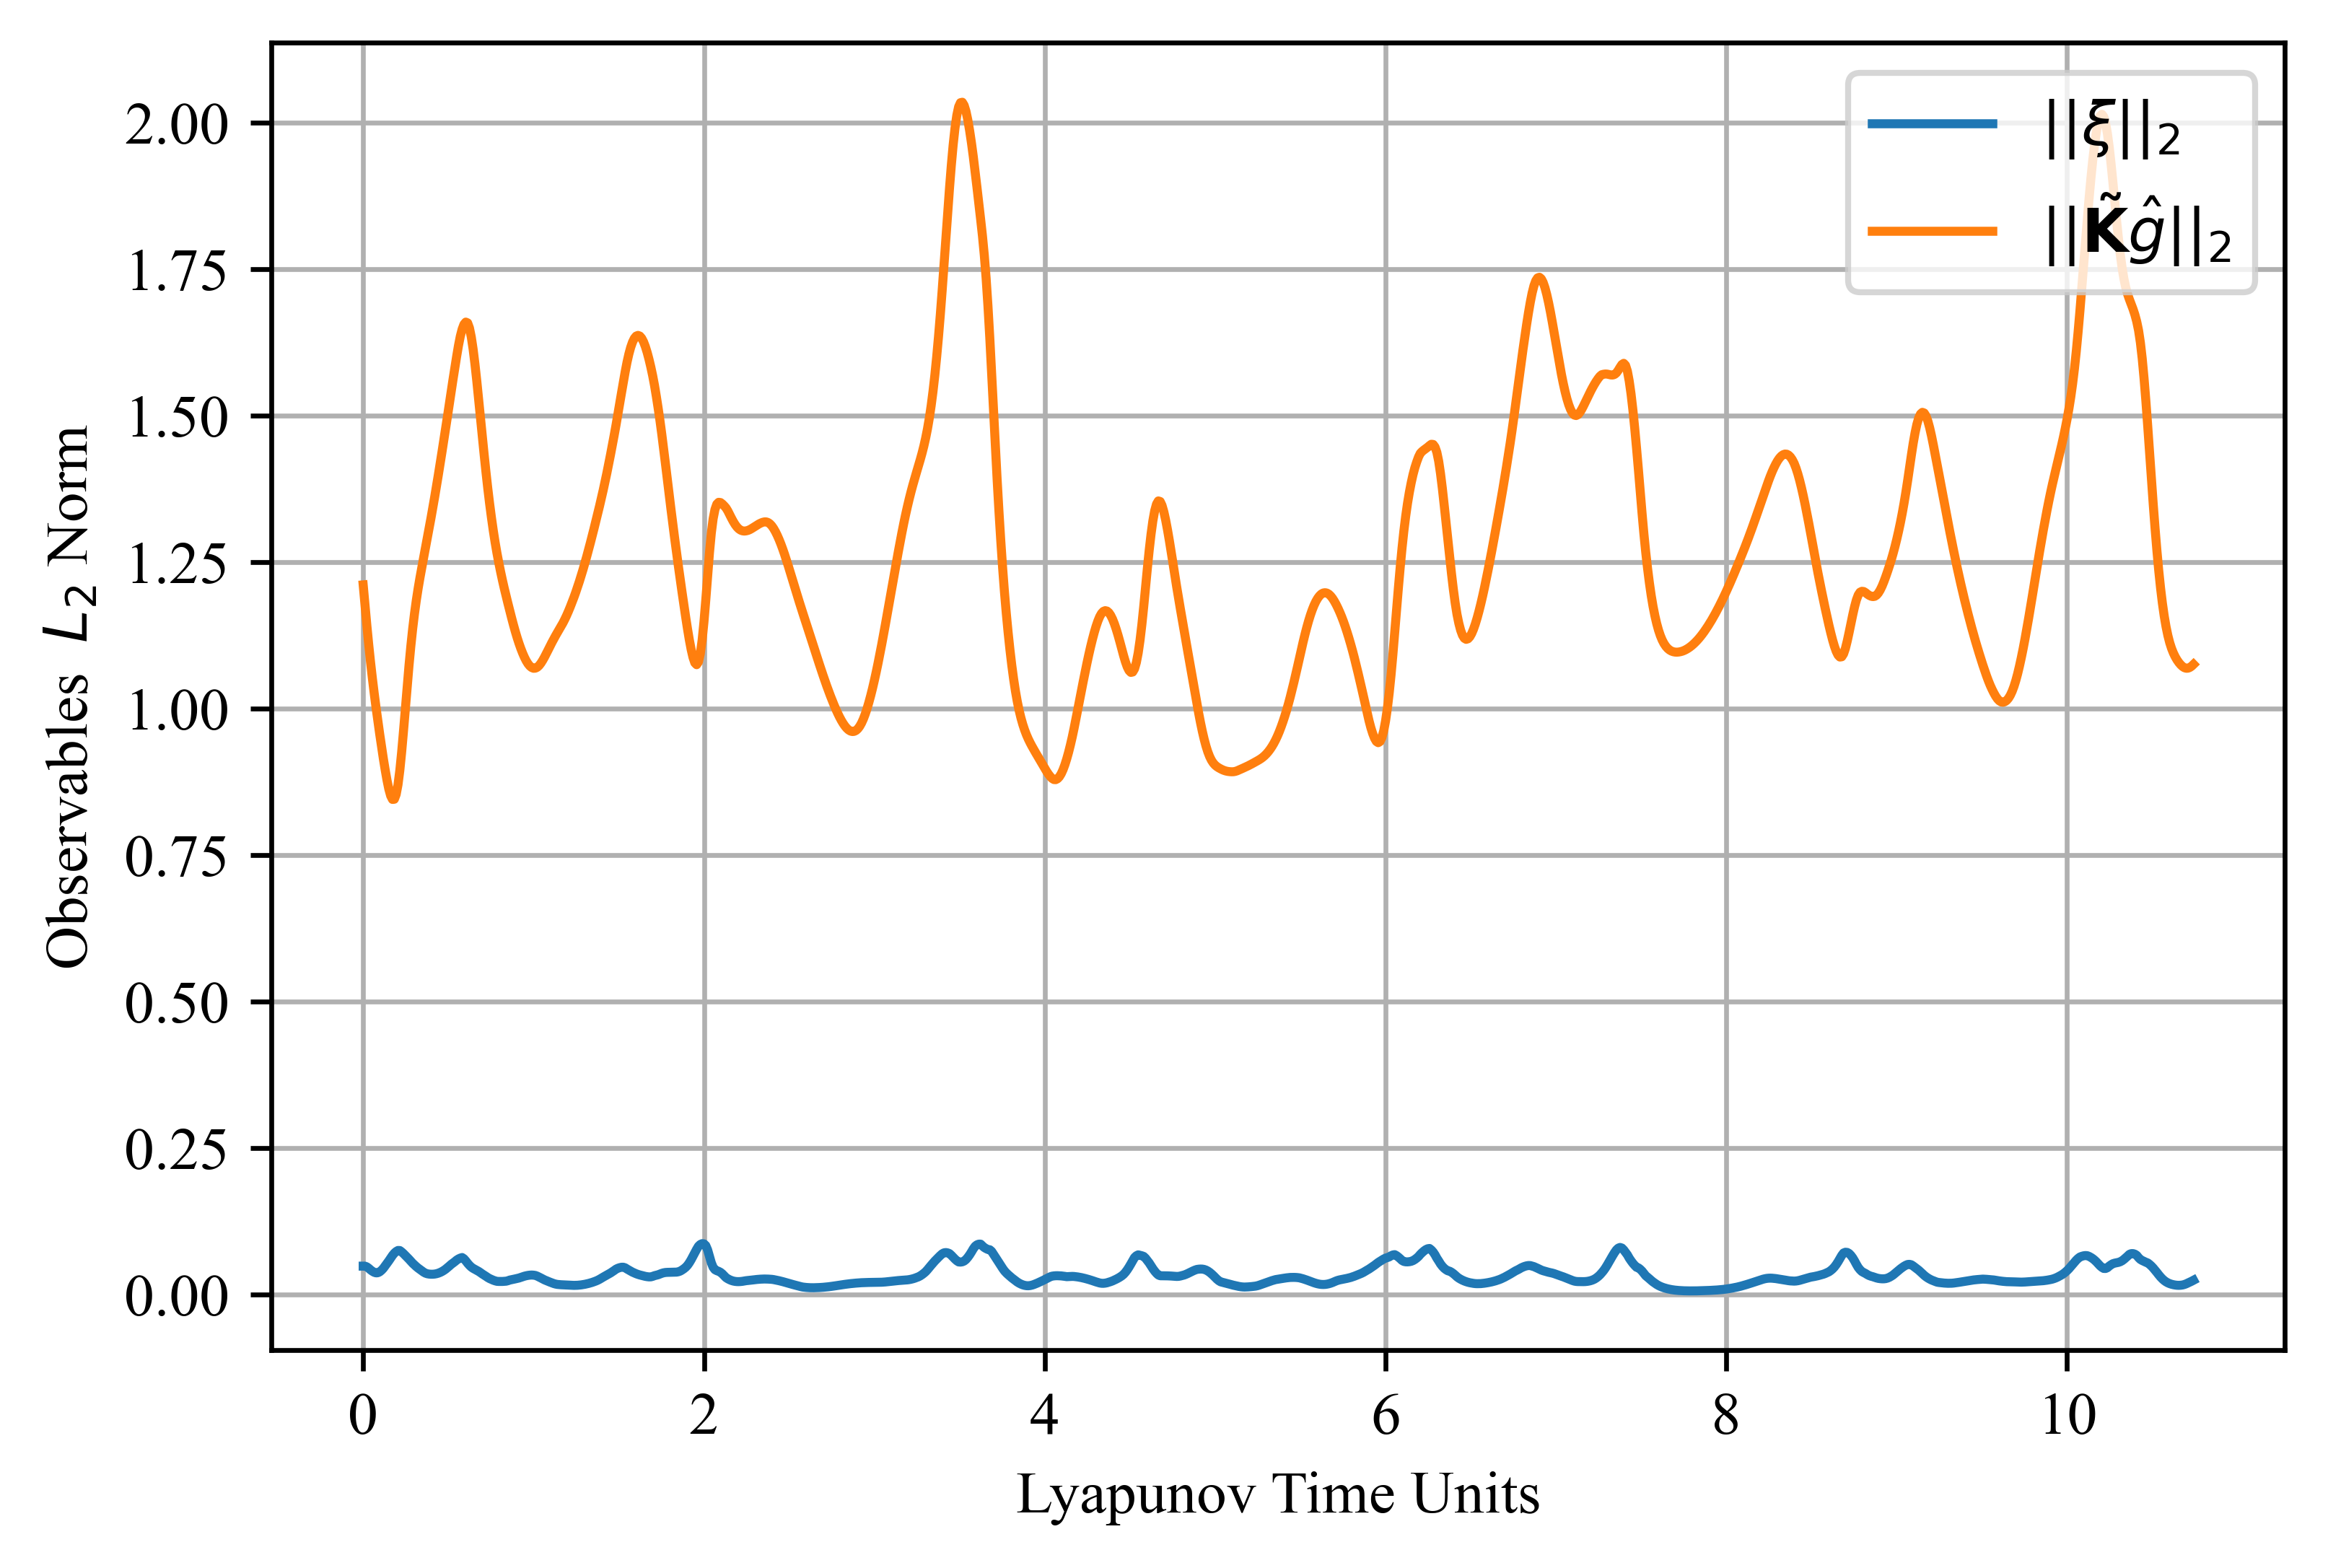

In [25]:
#plotting seqmodel mode evolution (Figure 6b)
plt.figure()
timesteps_ke = 1000
x = np.arange(timesteps_ke)/lt

model_num = 0
tgt_xseq_ms_hat = xseq_ms_hat[model_num].cpu().numpy()
tgt_xkoop_ms_hat = xkoop_ms_hat[model_num].cpu().numpy()

plt.figure(dpi = 600)
tgt_xseq_norm = np.linalg.norm(tgt_xseq_ms_hat, axis = -1)
tgt_xkoop_norm = np.linalg.norm(tgt_xkoop_ms_hat, axis = -1)


# plt.plot((tgt_xseq_norm/np.max(tgt_xseq_norm, axis = -1))[0,:], label = r"$||\Omega||_{2}$")
# plt.plot((tgt_xkoop_norm/np.max(tgt_xkoop_norm, axis = -1))[0,:], label = r"$||\mathcal{K}(x)||_{2}$")

plt.plot(x, (tgt_xseq_norm)[0,:timesteps_ke], label = r"$||\xi||_{2}$")
plt.plot(x, (tgt_xkoop_norm)[0,:timesteps_ke], label = r"$||\mathbf{\tilde{K}}\hat{g}||_{2}$")


plt.legend(loc = "upper right")
plt.xlabel("Lyapunov Time Units")
plt.grid("on")
plt.ylabel("Observables  " + r"$  L_{2}$" +  " Norm")


### Koopman Spectrum Study

Figure 7

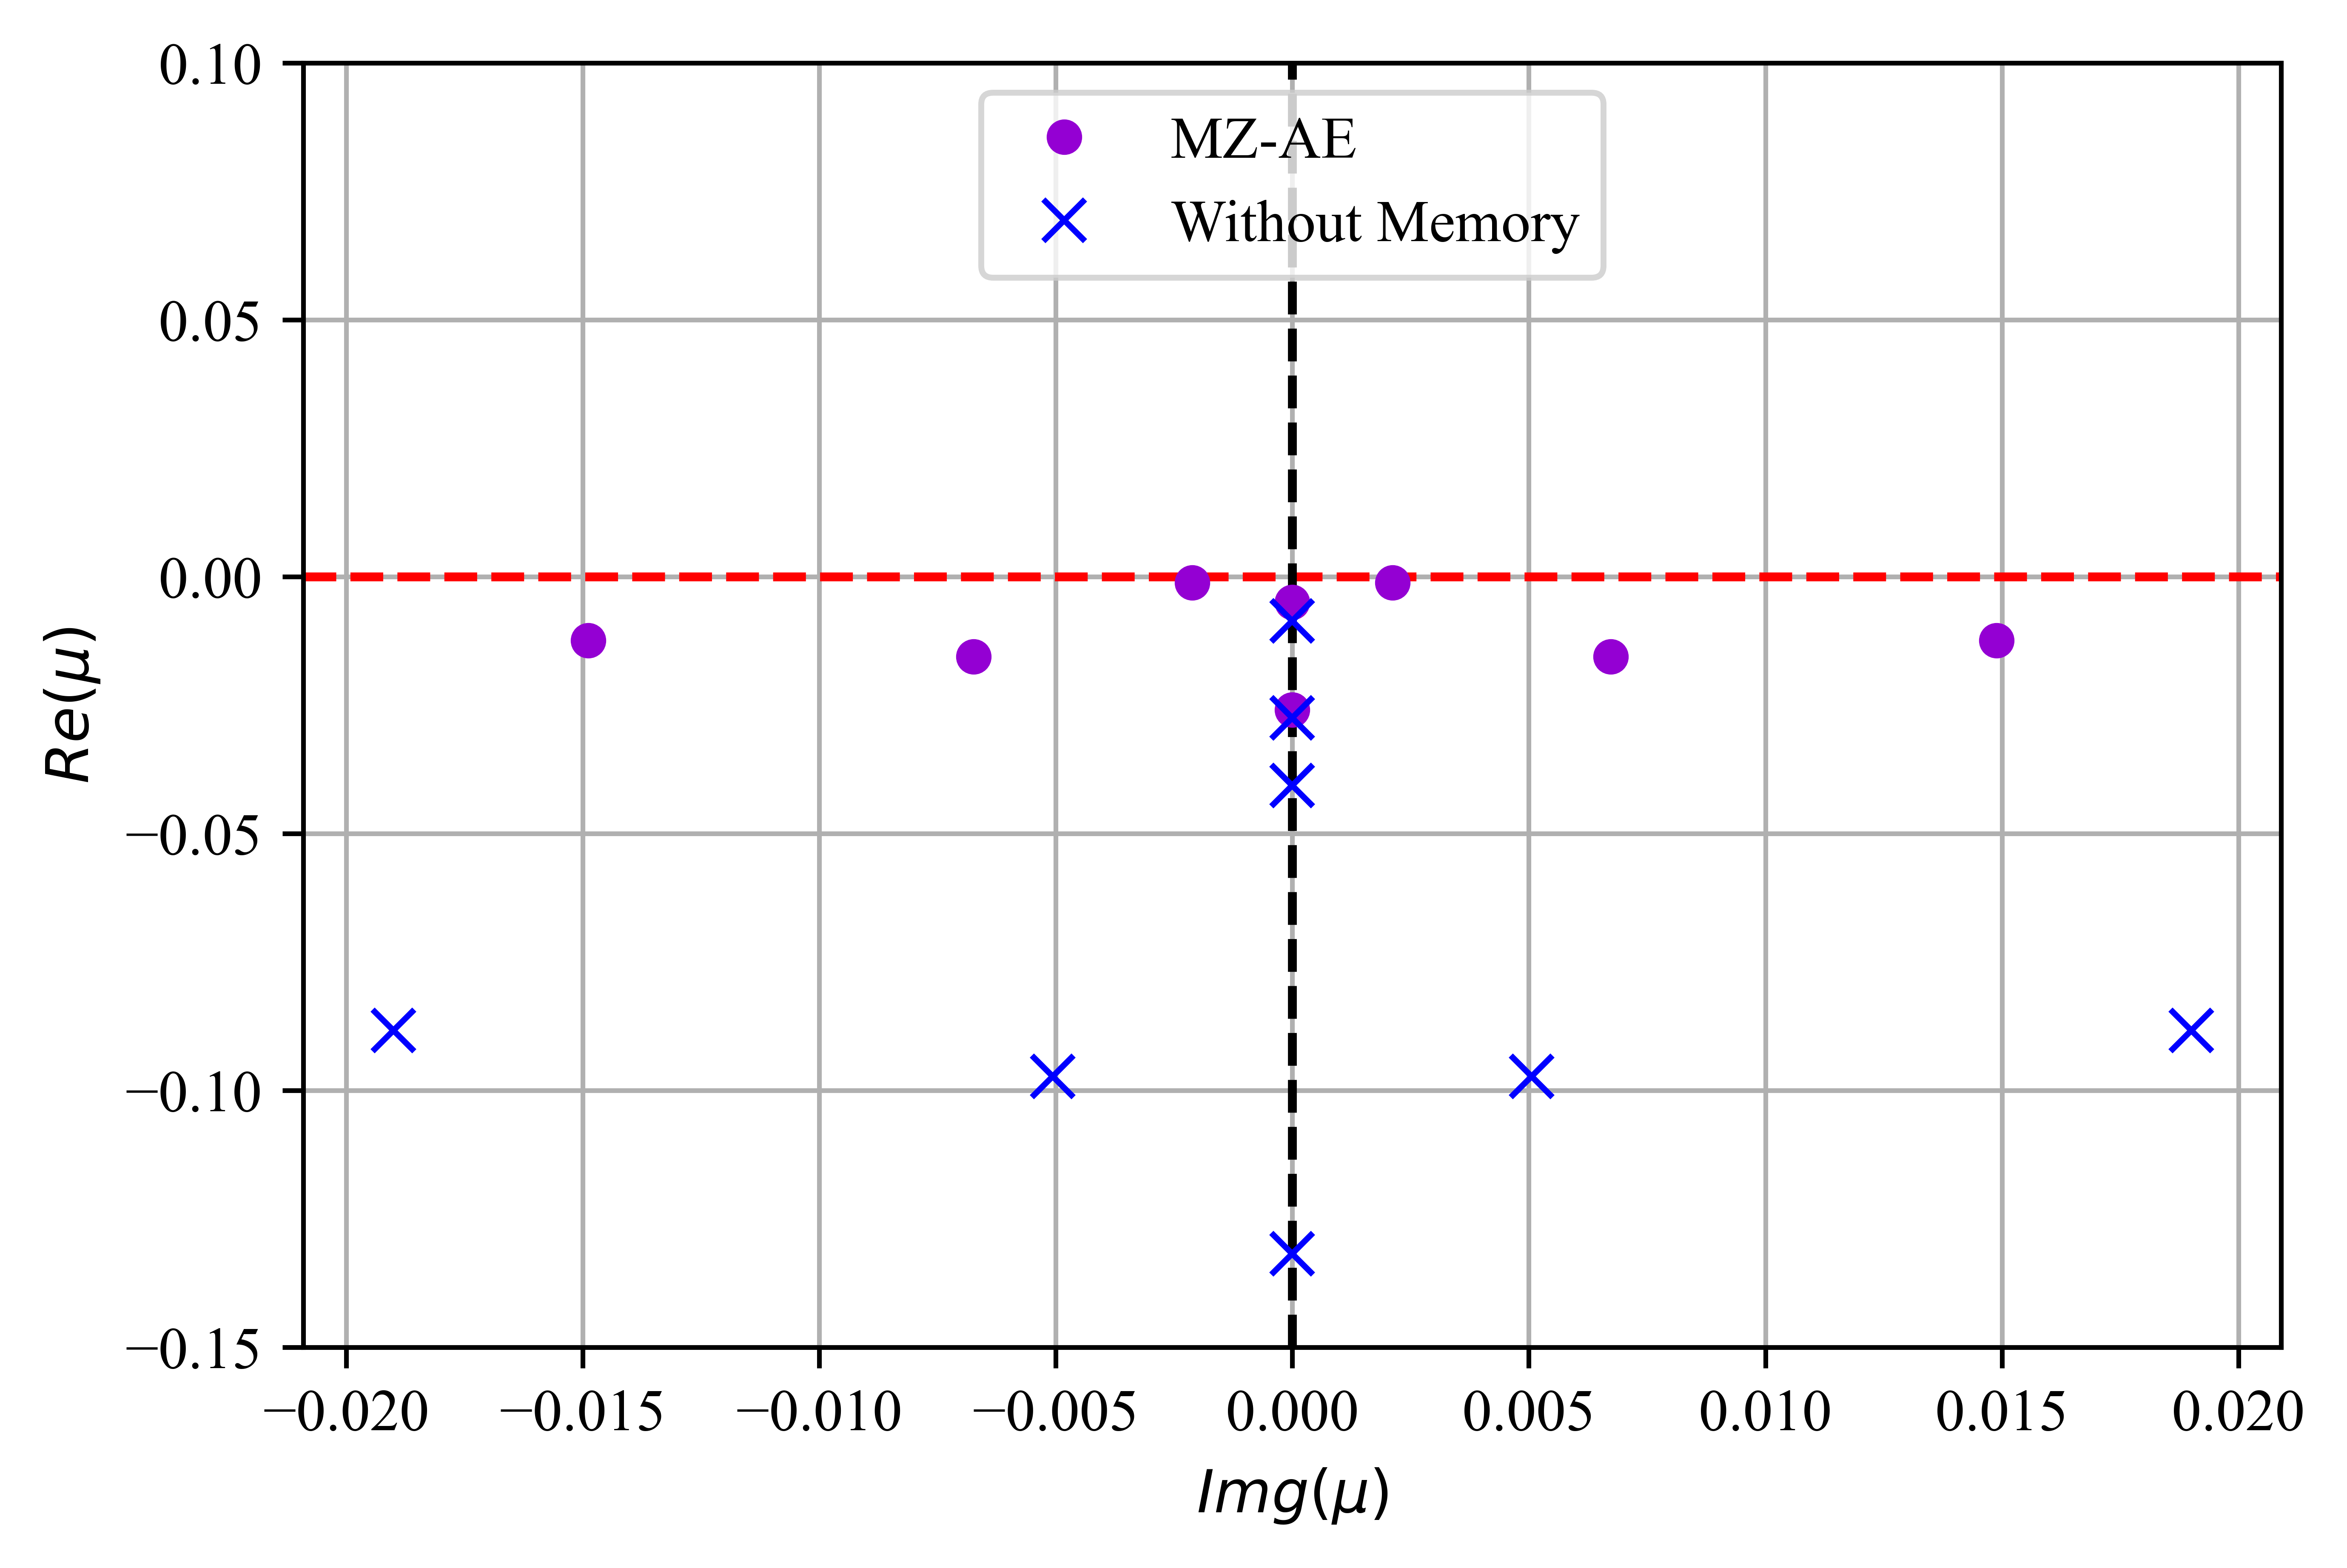

In [26]:
import copy
plt.figure(dpi = 1000)

plt.axhline(0, color='red', linestyle='--')
plt.axvline(x=0, color='black', linestyle='--')

for i in [0,1]:
    
    mat = models[i].model.koopman.getKoopmanMatrix()
    mat = mat.detach().cpu().numpy()
    w, v = np.linalg.eig(mat)

    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[:,idx]

    lamb = (np.log(w)/0.25)

    if i == 0:
        plt.plot(np.imag(lamb[:]),np.real(lamb[:]),".", color = "darkviolet", markersize = 10, label = "MZ-AE")
        lamb_mzae = copy.deepcopy(lamb)
    else:
        plt.plot(np.imag(lamb[:]),np.real(lamb[:]),"x", color = "blue", markersize = 7, label = "Without Memory")
        lamb_wm = copy.deepcopy(lamb)
plt.ylabel(r"$Re(\mu)$")
plt.xlabel(r"$Img(\mu)$")
plt.grid("on")
plt.ylim(-0.15,0.1)
plt.legend(loc = "upper center")

